# Regression (predicting unmasked value given (x, y, z, synapses))

### Step 1: Assumptions
Assume that unmasked values, Y, follow some joint distribution $F_{Y \mid X}$ where $X$ is the set of data, which are vectors in $\mathbb{R}^4$ and its elements correspond to x coordinate, y coordinate, z coordinate, synapses, respectively.

### Step 2: Define model
Let the true values of unmasked correspond to the set $Y$, and let the joint distribution be parameterized by $\theta$. So for each $x_i \in X \textrm{ and } y_i \in Y \ , F(x;\theta)=y$. 

We want to find parameters $\hat \theta$ such that we minimize the loss function $l(\hat y, y)$, where $\hat y = F(x;\hat \theta)$.

### Step 3: Algorithms
Linear Regression
Support Vector Regression (SVR)
K-Nearest Neighbor Regression (KNN)
Random Forest Regression (RF)
Polynomial Regression


### Step 4/5/6 part A: Null distribution

No relationship, i.e. all variables independent, so joint can be factored into marginals. Let's just let all marginals be uniform across their respective min and max in the actual dataset. So the target variable Y, i.e. unmasked, follows a multivariate uniform distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib2

%matplotlib inline

sample_size = 10000
k_fold = 10
np.random.seed(1)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

mins = [np.min(csv[:,i]) for i in xrange(5)]
maxs = [np.max(csv[:,i]) for i in xrange(5)]
domains = zip(mins, maxs)
Y_range = domains[3]
del domains[3]


null_X = np.array([[np.random.randint(*domains[i]) for i in xrange(4)] for k in xrange(sample_size)])
null_Y = np.array([[np.random.randint(*Y_range)] for k in xrange(sample_size)])

# Sample sizes from each synthetic data distribution
S = np.array((100, 120, 200, 320,
              400, 800, 1000, 2500, 5000, 7500))

# load our regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
r2 = np.zeros((len(S), len(regressions), 2), dtype=np.dtype('float64'))

#iterate over sample sizes and regression algos
for idx1, N in enumerate(S):
    # Randomly sample from synthetic data with sample size N
    a = np.random.permutation(np.arange(sample_size))[:N]
    X = null_X[a]
    Y = null_Y[a]
    Y = np.ravel(Y)

    for idx2, reg in enumerate(regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=10)
        r2[idx1, idx2, :] = [scores.mean(), scores.std()]
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

R^2 of Linear Regression: -0.18 (+/- 0.38)
R^2 of SVR: -0.25 (+/- 0.65)
R^2 of KNN Regression: -0.10 (+/- 0.30)
R^2 of Random Forest Regression: -0.16 (+/- 0.39)
R^2 of Polynomial Regression: -0.16 (+/- 0.38)
R^2 of Linear Regression: -0.16 (+/- 0.48)
R^2 of SVR: -0.43 (+/- 0.80)
R^2 of KNN Regression: -0.15 (+/- 0.58)
R^2 of Random Forest Regression: -0.22 (+/- 0.49)
R^2 of Polynomial Regression: -0.14 (+/- 0.61)
R^2 of Linear Regression: -0.07 (+/- 0.20)
R^2 of SVR: -0.37 (+/- 0.64)
R^2 of KNN Regression: -0.13 (+/- 0.30)
R^2 of Random Forest Regression: -0.16 (+/- 0.29)
R^2 of Polynomial Regression: -0.07 (+/- 0.36)
R^2 of Linear Regression: -0.05 (+/- 0.13)
R^2 of SVR: -0.15 (+/- 0.37)
R^2 of KNN Regression: -0.18 (+/- 0.26)
R^2 of Random Forest Regression: -0.13 (+/- 0.16)
R^2 of Polynomial Regression: -0.09 (+/- 0.18)
R^2 of Linear Regression: -0.07 (+/- 0.15)
R^2 of SVR: -0.21 (+/- 0.32)
R^2 of KNN Regression: -0.17 (+/- 0.25)
R^2 of Random Forest Regression: -0.09 (+/- 0.15)
R^

Now graphing this data:

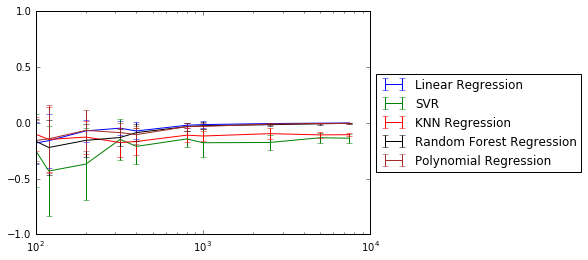

In [2]:
plt.errorbar(S, r2[:,0,0], yerr = r2[:,0,1], hold=True, label=names[0])
plt.errorbar(S, r2[:,1,0], yerr = r2[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, r2[:,2,0], yerr = r2[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, r2[:,3,0], yerr = r2[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(S, r2[:,4,0], yerr = r2[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 4/5/6 part b: Alternate distribution

Here we want a strong relationship between variables. Let's keep the x, y, z uniformly distributed across the sample space, but let # of synapses, s, be a deterministic function, f, of x, y, z. Let $s=f(x,y,z)=\frac{x+y+z}{3}$. Now let's say our random variable $Y=(s/4)+\epsilon$ where $\epsilon$ is some Gaussian noise with variance equal to average(s/4) (just to make this synthetic data slightly more realistic).

In [3]:
alt_X = np.apply_along_axis(lambda row : np.hstack((row[0:3], np.average(row[0:3]))), 1, null_X)
std_dev = np.sqrt(np.average(alt_X[:, 3]))
alt_Y = alt_X[:, 3]/4 + np.random.normal(scale=std_dev, size=(sample_size,))
r2 = np.zeros((len(S), len(regressions), 2), dtype=np.dtype('float64'))
#iterate over sample sizes and regression algos
for idx1, N in enumerate(S):
    # Randomly sample from synthetic data with sample size N
    a = np.random.permutation(np.arange(sample_size))[:N]
    X = alt_X[a]
    Y = alt_Y[a]
    Y = np.ravel(Y)

    for idx2, reg in enumerate(regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
        r2[idx1, idx2, :] = [scores.mean(), scores.std()]
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

R^2 of Linear Regression: 0.82 (+/- 0.18)
R^2 of SVR: 0.53 (+/- 0.37)
R^2 of KNN Regression: 0.77 (+/- 0.15)
R^2 of Random Forest Regression: 0.74 (+/- 0.16)
R^2 of Polynomial Regression: 0.79 (+/- 0.22)
R^2 of Linear Regression: 0.88 (+/- 0.07)
R^2 of SVR: 0.66 (+/- 0.50)
R^2 of KNN Regression: 0.82 (+/- 0.12)
R^2 of Random Forest Regression: 0.81 (+/- 0.10)
R^2 of Polynomial Regression: 0.87 (+/- 0.06)
R^2 of Linear Regression: 0.87 (+/- 0.10)
R^2 of SVR: 0.72 (+/- 0.42)
R^2 of KNN Regression: 0.84 (+/- 0.08)
R^2 of Random Forest Regression: 0.82 (+/- 0.10)
R^2 of Polynomial Regression: 0.86 (+/- 0.09)
R^2 of Linear Regression: 0.87 (+/- 0.08)
R^2 of SVR: 0.77 (+/- 0.30)
R^2 of KNN Regression: 0.84 (+/- 0.11)
R^2 of Random Forest Regression: 0.83 (+/- 0.07)
R^2 of Polynomial Regression: 0.87 (+/- 0.08)
R^2 of Linear Regression: 0.88 (+/- 0.05)
R^2 of SVR: 0.52 (+/- 1.05)
R^2 of KNN Regression: 0.86 (+/- 0.05)
R^2 of Random Forest Regression: 0.82 (+/- 0.07)
R^2 of Polynomial Regressi

Now graphing it:

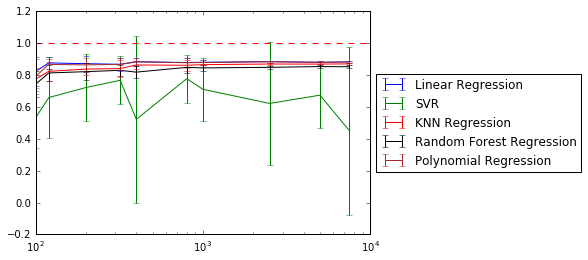

In [4]:
plt.errorbar(S, r2[:,0,0], yerr = r2[:,0,1], hold=True, label=names[0])
plt.errorbar(S, r2[:,1,0], yerr = r2[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, r2[:,2,0], yerr = r2[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, r2[:,3,0], yerr = r2[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(S, r2[:,4,0], yerr = r2[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 7: Apply on actual data

In [5]:
X = csv[:, [0, 1, 2, 4]]
Y = csv[:, 3]
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

R^2 of Linear Regression: 0.62 (+/- 0.40)
R^2 of SVR: 0.57 (+/- 0.18)
R^2 of KNN Regression: 0.25 (+/- 2.54)
R^2 of Random Forest Regression: 0.79 (+/- 0.51)
R^2 of Polynomial Regression: 0.85 (+/- 0.27)


### Step 8: Reflect on results
Update this part. *The regression accuracy on real data based on the five tested regression algorithms is, at best, 85%, and, at worst, 41%. From the poor results of the linear regression and linear support vector, we see that the relationship between the variables (x,y,z,synapses) and the unmasked value is definitely not linear. Also, since the polynomial regression of degree 2 failed, we know that the relationship between those variables is not quadratic. We believe K-nearest neighbors failed to the high dimensionality of our data. Distances become less representative of the data with increasing dimensionaltiy. Next, we plan to investigate why random forests performed so well and review our assumptions for accuracy and completeness as well as adjust our regression algorithm parameters to better represent the true data as well as the adjusted assumptions.*
